# Simulation and Performance Evaluation - Homework 4

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

Let's start defining the different types of event that we will use.

In [1]:
from enum import Enum

class EventTypes(Enum):
    start_simulation = 0,
    end_simulation = 1,
    packet_arrival = 2,
    packet_departure = 3,
    debug = 4

The following is the class representing an event. Its properties are the occurrence time, the type of the event and the pointer to the next occurring event.

In [2]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.next_event = None

Now, we need a class representing the Queue. It has a property pointing to the first event of the queue.
It's defined a method to insert an event in the queue linking it between the two events occurring immediatly before and after the event we are inserting.
There is a useful method to print the whole queue following the links between the events.
The last method of the Queue class extracts the first element of the queue removing it.

In [3]:
class Queue:
    def __init__(self):
        self.first_event = None


    def insert_event(self, event:Event):
        if event.occurrence_time < self.first_event.occurrence_time:
            event.next_event = self.first_event
            self.first_event = event
        else:
            curr_event = self.first_event
            while curr_event.next_event is not None and \
                    event.occurrence_time > curr_event.next_event.occurrence_time:
                curr_event = curr_event.next_event

            event.next_event = curr_event.next_event
            curr_event.next_event = event


    def print(self):
        curr_event = self.first_event
        while curr_event is not None:
            print("->", curr_event.occurrence_time, curr_event.event_type)
            curr_event = curr_event.next_event


    def pop(self):
        if self.first_event is None:
            return None

        curr_event = self.first_event
        self.first_event = self.first_event.next_event

        return curr_event

To be certain that the previous code works properly let's give it a try creating the simulation start and end events, adding them to the Queue and printing its content.

In [4]:
queue = Queue()
curr_time = 0
max_time = 1000

start_event = Event(curr_time, EventTypes.start_simulation)
end_event = Event(max_time, EventTypes.end_simulation)

queue.first_event = start_event
queue.insert_event(end_event)

queue.print()

-> 0 EventTypes.start_simulation
-> 1000 EventTypes.end_simulation


We can even try adding some events not ordered and check that queue automatically put them in the correct order while inserting them.

In [5]:
events = [
    Event(100, EventTypes.packet_departure),
    Event(842, EventTypes.packet_departure),
    Event(684, EventTypes.packet_arrival),
    Event(354, EventTypes.packet_arrival),
    Event(956, EventTypes.packet_departure),
    Event(715, EventTypes.debug),
    Event(20, EventTypes.packet_arrival),
    Event(953, EventTypes.packet_departure)
]

for e in events:
    queue.insert_event(e)

queue.print()

-> 0 EventTypes.start_simulation
-> 20 EventTypes.packet_arrival
-> 100 EventTypes.packet_departure
-> 354 EventTypes.packet_arrival
-> 684 EventTypes.packet_arrival
-> 715 EventTypes.debug
-> 842 EventTypes.packet_departure
-> 953 EventTypes.packet_departure
-> 956 EventTypes.packet_departure
-> 1000 EventTypes.end_simulation


Now, we need a class for the server. Every server should have a queue of the packets to be processed and a status, stating if the server is busy (`1`) or free (`0`).

In [6]:
class Server:
    def __init__(self):
        self.server_status = 0  # 0 means available, 1 means busy
        self.queue = []

The following code is a skeleton of the workflow adopted to manage a queue of events.

In [7]:
while True:
    event = queue.pop()
    if event is None:
        continue
    if event.event_type == EventTypes.start_simulation:
        print("start simulation")
    elif event.event_type == EventTypes.packet_arrival:
        print("packet arrival")
    elif event.event_type == EventTypes.packet_departure:
        print("packet departure")
    elif event.event_type == EventTypes.debug:
        print("debug")
    elif event.event_type == EventTypes.end_simulation:
        print("end simulation")
        break

start simulation
packet arrival
packet departure
packet arrival
packet arrival
debug
packet departure
packet departure
packet departure
end simulation


Let's define two functions. The first one simply extract a number from an exponential distribution given the lambda parameter.
The second one simulates the arrival of some packets to our server using the first function to decide the inter-arrival time.

In [8]:
import random as rnd


def exponential_val(lambda_val):
    return rnd.expovariate(lambda_val)


def simulate(arr_val, max_time):
    curr_time = 0
    queue = Queue()

    arrival_time = exponential_val(arr_val)
    curr_time += arrival_time

    queue.first_event = Event(curr_time, EventTypes.start_simulation)

    while curr_time < max_time:
        arrival_time = exponential_val(arr_val)
        curr_time += arrival_time

        if curr_time >= max_time:
            e = Event(curr_time, EventTypes.end_simulation)
        else:
            e = Event(curr_time, EventTypes.packet_arrival)

        queue.insert_event(e)

    return queue

The following function is an evolution of the skeleton defined before, managing the arrival of a packet and scheduling its departure sampling from the exponential distribution.

In [9]:
def manage_packets(q, server, server_lambda):
    packet_time = []
    packet_status = []
    delay_in_queue = []

    while True:
        event = q.pop()
        
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            if server.server_status == 0:  # server free
                server.server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)
                
                delay_in_queue.append(0)
            else:  # server busy
                server.queue.append(event)
        elif event.event_type == EventTypes.packet_departure:
            if len(server.queue) == 0:
                server.server_status = 0
            else:  # schedule next departure event
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)

                delay_in_queue.append(event.occurrence_time - server.queue[0].occurrence_time)
                server.queue.pop(0)  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            packet_time.append(event.occurrence_time)
            num_packets = len(server.queue) + server.server_status
            packet_status.append(num_packets)
        elif event.event_type == EventTypes.end_simulation:
            break


    return packet_time, packet_status, delay_in_queue

The following is a useful function that uses the functions defined previously.
It simulates the arrival and the departure of some packets and then plots the average number of packets in the system, sampled every 5 seconds, comparing it with the theoretical average value.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_simulation(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    for i in range(0, max_time, 5):
        q.insert_event(Event(i, EventTypes.debug))
    
    s = Server()
    packet_time, packet_status, _ = manage_packets(q, s, mu)

    mean_values = [sum(packet_status[:i+1])/(i+1) for i in range(len(packet_status))]
    plt.plot(packet_time, mean_values)

    p = lmbda / mu
    theory_val = p/(1-p)
    theoretical = [theory_val] * len(packet_time)

    
    plt.plot(packet_time, theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Average number of packets in the system')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Average number of packets in the system - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

As can be seen from the following plots, when the lambda is higher than the mu, the growth of the number of packets in the system is linear.
This means that the server takes too much time to manage a packet and some new packets are generated in the meantime.

The theoretical average number of packets in the system can be taken as valid only when the system is in stationary conditions.
If $\lambda > \mu$ we cannot have stationary conditions: too many packets arrive to the server.

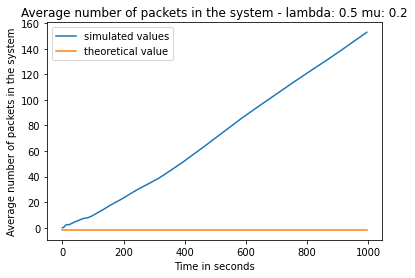

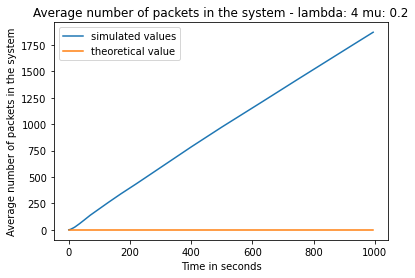

In [11]:
plot_simulation(0.5, 0.2, 1000)
plot_simulation(4, 0.2, 1000)

When $\lambda < \mu$, as said before, the system is in stationary conditions and the server is able to manage all the packets as confirmed by the following plots.

With the going on of the simulation, the simulated function tends to converge to the theoretical one.

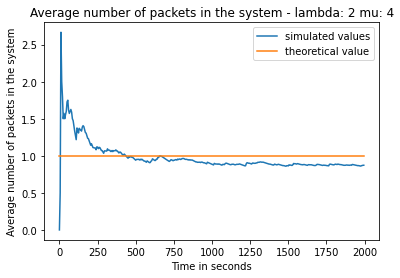

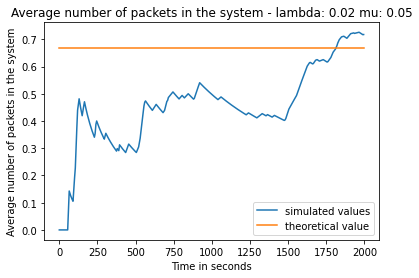

In [12]:
plot_simulation(2, 4, 2000)
plot_simulation(0.02, 0.05, 2000)

When lambda is slightly lower than the mu, the system is again in stationary conditions, but, as can be seen from the following plots, the empirical function takes a lot more time to converge to the theoretical value.

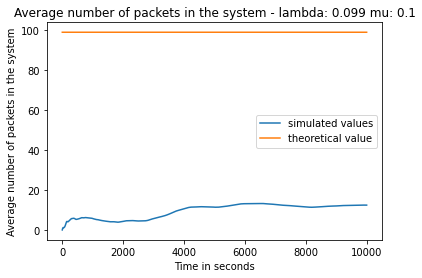

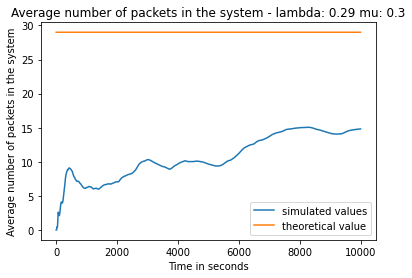

In [13]:
plot_simulation(0.099, 0.1, 10000)
plot_simulation(0.29, 0.3, 10000)

Let's define some functions that will be useful later on to compute mean, standard deviation and confidence interval for the mean of some data.

In [14]:
from math import sqrt

def compute_mean(values):
    tot = 0
    for i in values:
        tot += i
    return tot / len(values)

def compute_std_dev(values):
    mean = compute_mean(values)
    tot = 0
    for i in values:
        tot += (i - mean) ** 2
    return sqrt(tot / len(values))

def mean_interval(data, gamma):
    eta = None
    if gamma == 0.95:
        eta = 1.960
    elif gamma == 0.99:
        eta = 2.576
    else:
        # in these excercises we are only interested in 95% and 99% confidence
        pass
    mean = compute_mean(data)
    std_dev = compute_std_dev(data)
    incr = eta * std_dev / sqrt(len(data))
    return mean - incr, mean + incr

The following function runs a simulation and calculates the average time that every packet has to wait in the queue before being served by the server. The obtained value and its 95% Confidence Interval are compared with the theoretical value.

In [15]:
def calc_simulation_wait(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, packet_wait = manage_packets(q, s, mu)

    p = lmbda / mu
    theory_val = p**2 / (lmbda * (1-p))
    theoretical = [theory_val] * len(packet_wait)

    mean_wait = compute_mean(packet_wait)
    low, up = mean_interval(packet_wait, 0.95)

    print("Lambda: {}, Mu: {}".format(lmbda, mu))
    print("Simulated mean time in queue: {:0.3f}".format(mean_wait))
    print("95% C.I. for the mean: [{:0.3f}, {:0.3f}]".format(low, up))
    print("Theoretical mean time in queue: {:0.3f}".format(theory_val))

With a simulation in stationary conditions the resulting average time in queue of a packet variates a bit at every execution but pretty every time its 95% C.I. contains the theoretical value.

In [16]:
calc_simulation_wait(2, 4, 2000)

Lambda: 2, Mu: 4
Simulated mean time in queue: 0.256
95% C.I. for the mean: [0.243, 0.269]
Theoretical mean time in queue: 0.250


With $\lambda = 1$, $\mu = 4$ and $max\_time = 2000$ our system seems to alternate transient and steady-state system condition. There is an initial phase where the system is in warm-up, while at the end it is more stable and tends to converge to the theoretical value. 

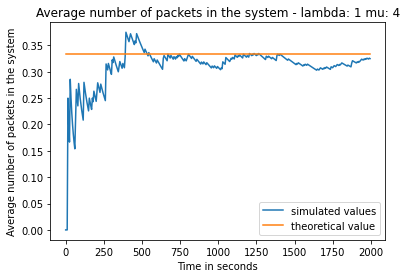

In [17]:
plot_simulation(1, 4, 2000)

With the following function we can plot the empirical distribution of the number of packets in the system and of the queue waiting time running the simulation 500 times and averaging the results.

We plot the empirical distribution of the average packets in the system in the first 100 seconds and in the last 100 ones. So in the initial phase where the system is in a transient condition and in the final phase where the system is in steady-state conditions.

We even plot the empirical distribution of first 50 packets in the system and of the last 50 packets of the system.

In [18]:
def plot_distribution(lmbda, mu, max_time):
    values_ps_first = []
    values_ps_second = []
    values_pw_first = []
    values_pw_second = []
    for i in range(500):
        q = simulate(lmbda, max_time)
        for i in range(0, max_time, 5):
            q.insert_event(Event(i, EventTypes.debug))
        s = Server()
        packet_time, packet_status, packet_wait = manage_packets(q, s, mu)
        
        values_ps_first.append(compute_mean(packet_status[:20]))
        values_ps_second.append(compute_mean(packet_status[:-20]))
        
        values_pw_first.append(compute_mean(packet_wait[:50]))
        values_pw_second.append(compute_mean(packet_wait[:-50]))

    plt.hist(values_ps_first, bins=20)
    plt.title('Packets in the system distribution, first 100 seconds')
    plt.show()
    
    plt.hist(values_ps_second, bins=20)
    plt.title('Packets in the system distribution, last 100 seconds')
    plt.show()

    plt.hist(values_pw_first, bins=20)
    plt.title('Queue waiting time distribution, first 50 packets')
    plt.show()

    plt.hist(values_pw_second, bins=20)
    plt.title('Queue waiting time distribution, last 50 packets')
    plt.show()

Analysing the following plots, it can be noticed that the empirical distribution of the number of packets in the system and the one describing the queue waiting time, seems to behaves in more or less the same way in the same phase of the simulation.

When the system is in transient condition the queue waiting time of the first 50 packets seems to behave like a Lognomial distribution, while the distribution of the average number of packets in the system in the first 100 seconds looks like a distribution between the Gaussian and the Lognomial one.

In the end of the simulation, when the system is in steady state conditions, both the distributions seems to behave like a Gaussian.

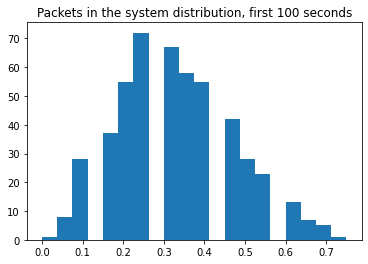

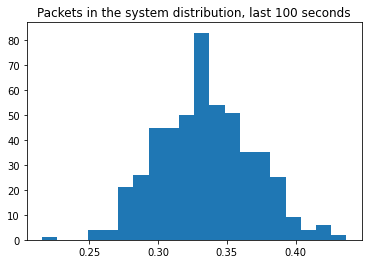

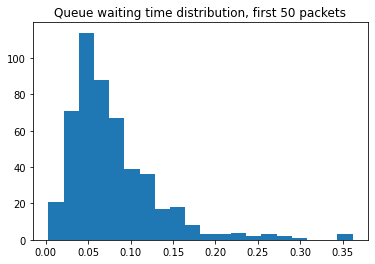

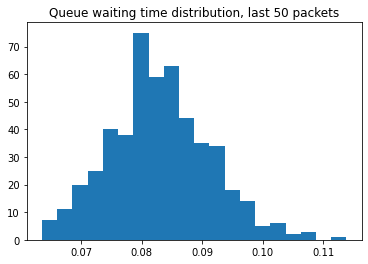

In [19]:
plot_distribution(1, 4, 2000)

## Exercise 2

Firstly, we need to modify the Event class previously defined in order to store the server which has elaborated the packet.

In [20]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.server_idx = None
        self.next_event = None

The following is a function capable to manage a queue of events and assign every packet to a server, giving priority to the one with a lower ID number.

To avoid editing the previous Server class, we decided to use the queue of the first Server as the global packet queue of the system.

In [21]:
def manage_packets_MMc(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    packet_time = []
    packet_status = []
    delay_in_queue = []
    
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            found = False
            for s in range(len(servers)):
                if servers[s].server_status == 0:  # server free
                    servers[s].server_status = 1
                    leave_int = exponential_val(server_lambda)
                    e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                    e.server_idx = s
                    packet_served[s] += 1
                    q.insert_event(e)
                    found = True
                    
                    delay_in_queue.append(0)
                    break
            if not found:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                for s in range(len(servers)):
                    if servers[s].server_status == 0:  # server free
                        servers[s].server_status = 1
                        leave_int = exponential_val(server_lambda)
                        e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                        e.server_idx = s
                        packet_served[s] += 1
                        q.insert_event(e)
                        
                        delay_in_queue.append(event.occurrence_time - servers[0].queue[0].occurrence_time)
                        servers[0].queue.pop(0)  # remove first packet from the queue
                        break
        elif event.event_type == EventTypes.debug:
            packet_time.append(event.occurrence_time)
            num_packets = len(servers[0].queue) + sum([s.server_status for s in servers])
            packet_status.append(num_packets)
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served, packet_time, packet_status, delay_in_queue

Now, let's define a function to simulate a M/M/c system and compute to average time that a packet has to wait in the queue, plot the average number of packets in the system and the load of every server.

In [22]:
def simulate_MMc(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)    
    for i in range(0, max_time, 5):
        q.insert_event(Event(i, EventTypes.debug))
    s = []
    for i in range(c):
        s.append(Server())
    packet_served, packet_time, packet_status, packet_wait = manage_packets_MMc(q, s, mu)

    mean_wait = compute_mean(packet_wait)
    low, up = mean_interval(packet_wait, 0.95)

    print("Lambda: {}, Mu: {}".format(lmbda, mu))
    print("Simulated mean time in queue: {:0.3f}".format(mean_wait))
    print("95% C.I. for the mean: [{:0.3f}, {:0.3f}]".format(low, up))
    
    mean_values = [sum(packet_status[:i+1])/(i+1) for i in range(len(packet_status))]
    plt.plot(packet_time, mean_values)
    plt.xlabel('Time in seconds')
    plt.ylabel('Average number of packets in the system')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Average number of packets in the system - lambda: {} mu: {}'.format(lmbda, mu))
    plt.show()
    
    
    plt.bar(range(c), packet_served)
    plt.title('Packets served by each server - lambda: {} mu: {}'.format(lmbda, mu))
    plt.show()

The following is a function to plot the distribution of the average number in the system and queue wainting time at the begining of the simulation and at the end of it.

In [23]:
def plot_distribution_MMc(lmbda, mu, max_time, c):
    values_ps_first = []
    values_ps_second = []
    values_pw_first = []
    values_pw_second = []
    for i in range(500):
        q = simulate(lmbda, max_time)    
        for i in range(0, max_time, 5):
            q.insert_event(Event(i, EventTypes.debug))
        s = []
        for i in range(c):
            s.append(Server())
        packet_served, packet_time, packet_status, packet_wait = manage_packets_MMc(q, s, mu)
        
        values_ps_first.append(compute_mean(packet_status[:20]))
        values_ps_second.append(compute_mean(packet_status[:-20]))
        
        values_pw_first.append(compute_mean(packet_wait[:50]))
        values_pw_second.append(compute_mean(packet_wait[:-50]))

    plt.hist(values_ps_first, bins=20)
    plt.title('Packets in the system distribution, first 100 seconds')
    plt.show()
    
    plt.hist(values_ps_second, bins=20)
    plt.title('Packets in the system distribution, last 100 seconds')
    plt.show()

    plt.hist(values_pw_first, bins=20)
    plt.title('Queue waiting time distribution, first 50 packets')
    plt.show()

    plt.hist(values_pw_second, bins=20)
    plt.title('Queue waiting time distribution, last 50 packets')
    plt.show()

Simulating the M/M/c system with 2 or 3 servers and different mu, we can observe that the first server always manage a lot of more packets than the second one. Same for the second Server with respect to the third one.

Because of the loading policy, the lower the server ID, the higher the number of packets managed by it.

Lambda: 0.1, Mu: 0.4
Simulated mean time in queue: 0.014
95% C.I. for the mean: [-0.006, 0.034]


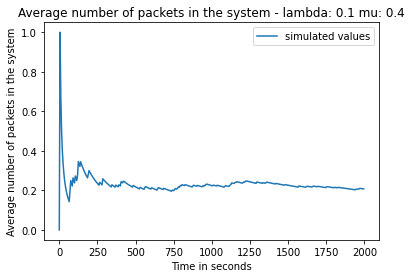

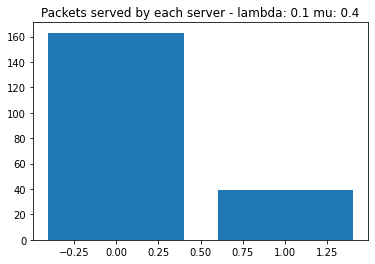

In [24]:
simulate_MMc(0.1, 0.4, 2000, 2)

As can be seen, the distribution's plots have slightly changed compared to the M/M/1 system.
The distribution of the average packets in the system in the first 100 seconds now looks like more a Lognomial distribution, while the distribution at the end of the simulation behaves like a Gaussian as before.

The two plots representing the distributions of the waiting time in the queue looks similar, but at the end of the simulation the distribution is a little bit more distributed, meaning that the packets have to wait a little more than at the beginning of the simulation. 

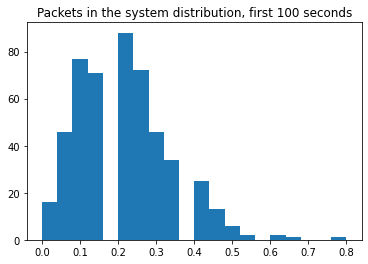

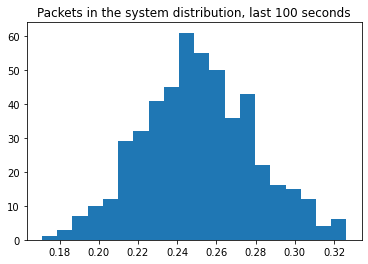

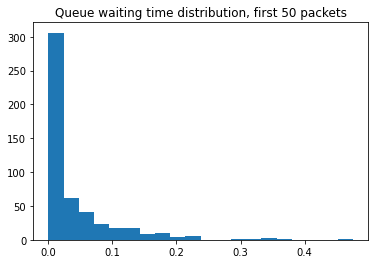

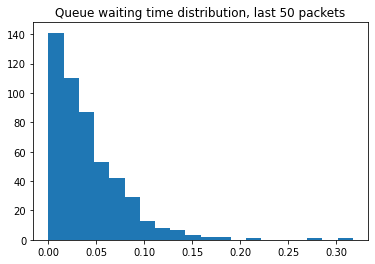

In [25]:
plot_distribution_MMc(0.1, 0.4, 2000, 2)

Lambda: 0.1, Mu: 1
Simulated mean time in queue: 0.000
95% C.I. for the mean: [0.000, 0.000]


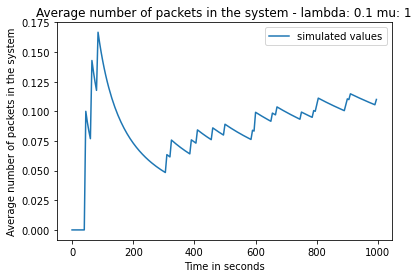

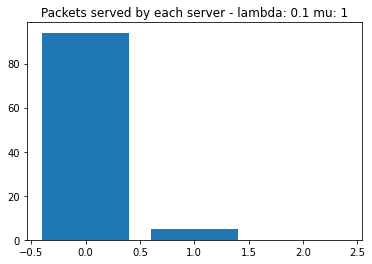

In [26]:
simulate_MMc(0.1, 1, 1000, 3)

To fix the problem of the unbalanced load on the servers, we have to implement a load balancer. To do this, we sample from a uniform distribution using the method `randrange`. In this way, we choose which server will manage the packet simply choosing from the free servers.

In [27]:
def get_server_balanced(servers):
    free_srv = []
    for s in range(len(servers)):
        if servers[s].server_status == 0:
            free_srv.append(s)

    if len(free_srv) == 0:
        return None
    srv = rnd.randrange(0, len(free_srv))
    return free_srv[srv]

def manage_packets_MMc_balanced(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            s = get_server_balanced(servers)

            if s is None:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
            else:
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                s = get_server_balanced(servers)
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)

                servers[0].queue = servers[0].queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served

In [28]:
def simulate_MMc_balanced(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)
    s = []
    for i in range(c):
        s.append(Server())
    packet_served = manage_packets_MMc_balanced(q, s, mu)

    plt.bar(range(c), packet_served)

    plt.title('Packet served by each server balanced - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

As can be seen from the following plots, with the load balancer implemented above, with different values of lambda and mu, the number of packets managed by each server is more or less always the same.

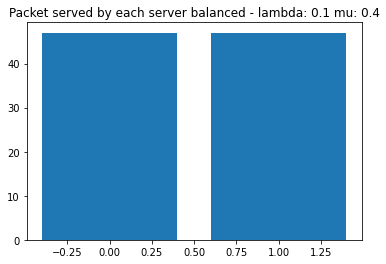

In [29]:
simulate_MMc_balanced(0.1, 0.4, 1000, 2)

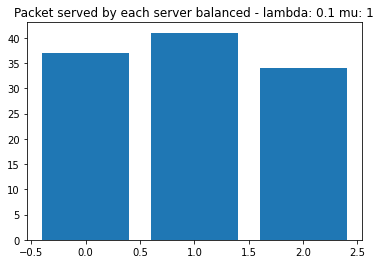

In [30]:
simulate_MMc_balanced(0.1, 1, 1000, 3)

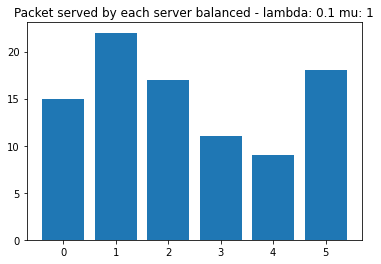

In [31]:
simulate_MMc_balanced(0.1, 1, 1000, 6)

## Exercise 3

Let's start by importing some useful libraries and by defining some functions and classes.

In [32]:
from random import uniform
from math import sqrt
from queue import PriorityQueue

The function `euclidean_distance(a,b)` computes the euclidean distance between point $a$ and point $b$.

In [33]:
def euclidean_distance(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

The class `EvenHandler` implements the queue of the events of the simulations. Under the hood, it is just a priority queue, which is a queue ordered by a certain key (priority). In the case of our exercise, the priority is the time of the event, and each event is encoded in a triple (time, type, node) where time is the time of the event, type is the name of the function to trigger associated to the event and node is the node which is involved in the event (sometimes node can be -1, which means all the nodes are involved in the event). 

In [34]:
class EventHandler:
    def __init__(self):
        self.events = PriorityQueue()
        
    def addEvent(self, e):
        self.events.put(e)
    
    def getEvent(self):
        return self.events.get()
    
    def isEmpty(self):
        return self.events.empty()

The class `Node` abstracts the concept of a node in the exercise. Each node is sampled in a certain area, and can generate the coordinates of a new waypoint to reach and the speed. Of course, there are multiple attributes we use to obtain the information we need during the simulation. This is more of a utility class which is useful to better manage situations in which there are more than one node. 

In [35]:
class Node:
    def __init__(self, maxX, maxY, minS, maxS):
        self.maxX = maxX
        self.maxY = maxY
        self.maxS = maxS
        self.minS = minS
        self.last_waypoint = -1
        self.getNewCoords()
        self.getNewWaypoint()
        self.getNewSpeed()
        
    def getNewCoords(self):
        self.x = uniform(0, self.maxX)
        self.y = uniform(0, self.maxY)
        
    def getNewWaypoint(self):
        self.next_waypoint_x = uniform(0, self.maxX)
        self.next_waypoint_y = uniform(0, self.maxY)
        
    def getNewSpeed(self):
        self.speed = uniform(self.minS, self.maxS)
        
    def getTimeNeeded(self):
        d = euclidean_distance((self.x, self.y), (self.next_waypoint_x, self.next_waypoint_y))
        return d / self.speed
    
    def arrived(self):
        self.x = self.next_waypoint_x
        self.y = self.next_waypoint_y
        self.getNewWaypoint()
        self.getNewSpeed()

The class `Simulation` implements all the function needed to perform a simulation: initialization, measurement of the average speed of each node every `time_measure` unit of time and assignment of a new waypoint every time a node reaches the target. The simulation stops after 3000 with a stop event.

In [36]:
class Simulation:
    def __init__(self, N, maxX, maxY, minS, maxS, time_measure):
        self.events = EventHandler()
        self.N = N
        self.maxX = maxX
        self.maxY = maxY
        self.maxS = maxS
        self.minS = minS
        self.time_measure = time_measure
        self.nodes = []
        self.events.addEvent((0, "init", -1))
        
    def init_event_handler(self):
        for n in range(self.N):
            self.nodes.append(Node(self.maxX, self.maxY, self.maxS, self.minS))
            self.events.addEvent((self.nodes[n].getTimeNeeded(), "waypoint_reached", n))
            
        self.events.addEvent((self.time_measure, 'measure_speed', -1))
        self.events.addEvent((3000, 'stop', -1))
                              
    def measure_speed(self, t):
        s = 0
        for node in self.nodes:
            s += node.speed
            
        self.events.addEvent((t + self.time_measure, 'measure_speed', -1))
        return s / self.N
    
    def waypoint_reached(self, i, t):
        self.nodes[i].arrived()
        self.events.addEvent((t + self.nodes[i].getTimeNeeded(), "waypoint_reached", i))
        
    def simulate(self):
        t = 0
        measures = []
        while True:
            event_time, event_type, event_node = self.events.getEvent()
            t = event_time
            if event_type == 'measure_speed':
                avg_speed = self.measure_speed(t)
                measures.append(avg_speed)
            elif event_type == 'init':
                self.init_event_handler()
            elif event_type == 'stop':
                break
            else:
                self.waypoint_reached(event_node, t)
        
        self.measures = measures

The function `run_set` runs `N_sim` simulations with `N_nodes` nodes and with `v_min` and `v_max` as the bounds on the speed sampling and returns the averages of the measures for each `measure_speed` event.

In [37]:
def run_set(N_sim, N_nodes, v_min, v_max):
    import numpy as np
    measures = None

    for i in range(N_sim):
        sim = Simulation(N_nodes, 100, 100, v_min, v_max, 25)
        sim.simulate()
        m = np.array(sim.measures)
        
        if measures is None:
            measures = m
        else:
            measures += m

    measures /= N_sim
    return measures

In [38]:
def plot_set(measures):
    mean = []
    for i in range(len(measures)):
        mean.append(sum(measures[:i+1]) / (i+1))
    
    plt.figure(figsize=(10,6))
    plt.plot(measures, label='avg speed of the nodes')
    plt.plot(mean, label='mean of the avg speed of the nodes')
    plt.xlabel("Speed measures (1 measure every 25 seconds)")
    plt.ylabel("Speed m/s")
    plt.legend()
    plt.show()

Now, let's try to run some simulations with different parameters, in this case we are asked to change the number of nodes and $v_\text{max}$, keeping $v_\text{min} = 0$. Every run in this case is made up of a single simulation.

N_nodes = 1, $v_\text{min} = 0$, $v_\text{max} = 10$

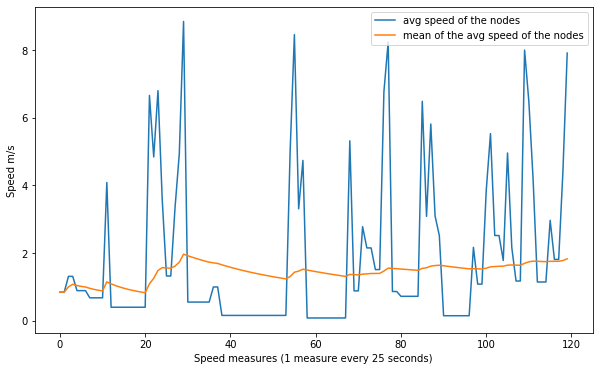

In [39]:
plot_set(run_set(1, 1, 0, 10))

N_nodes = 1, $v_\text{min} = 0$, $v_\text{max} = 20$

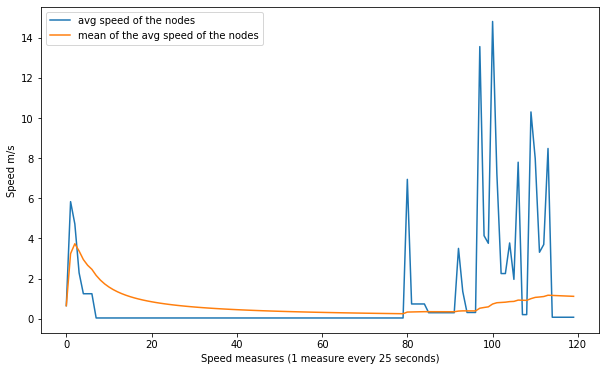

In [40]:
plot_set(run_set(1, 1, 0, 20))

N_nodes = 10, $v_\text{min} = 0$, $v_\text{max} = 10$

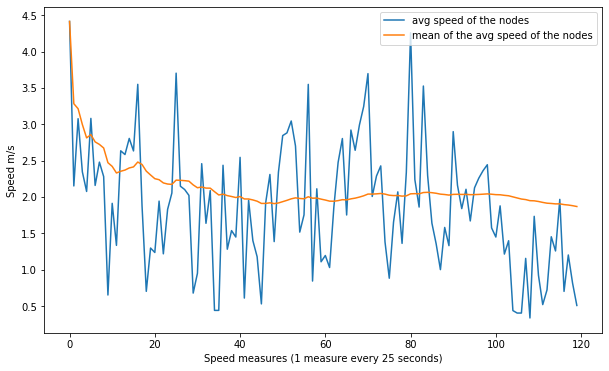

In [41]:
plot_set(run_set(1, 10, 0, 10))

N_nodes = 10, $v_\text{min} = 0$, $v_\text{max} = 20$

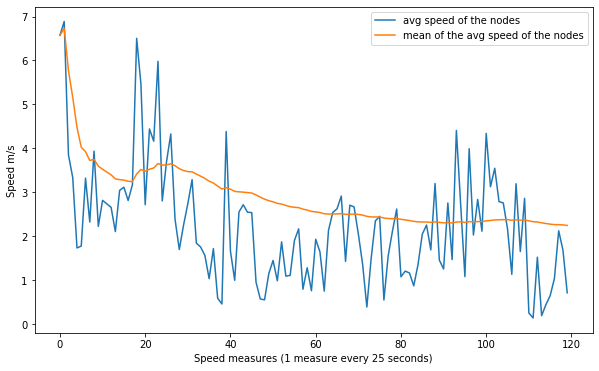

In [42]:
plot_set(run_set(1, 10, 0, 20))

In the previous plots we can notice an important pattern: if a node gets a really low speed it will affect a lot the average speed of the nodes, and also if the speed is really low it is likely the node will take a lot of time to reach its target waypoint, this means that the effect of sampling a low speed will affect the measures of the average speed of the nodes for a long time. This effect seems to be mitigated when the number of nodes increases, but still it is important; moreover if one of the node gets stuck on a low speed for a long time, it is likely that other nodes will experience the same behavior. In fact, we can notice how the mean of the measures of the average speed decreases in time. Changing the value of $v_\text{max}$ does not seem to affect that much the results.

Now we are asked to compare two sets of simulation: one with $v_\text{min} = 0$ and the other with $v_\text{min} = 1$, we fix $v_\text{max}=10$. Each set is made up of 200 simulations, for every measure of the average speed of the node we take the mean among the whole set of simulations. We repeat this two times, one with a single node in the experiments and another one with ten nodes in the experiments.

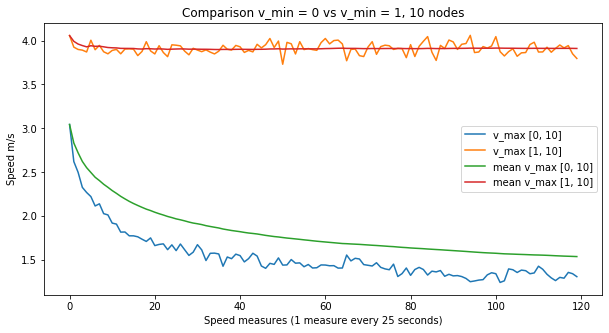

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def compare():
    def plot(measures0, measures1):  
        m0 = []
        for i in range(len(measures0)):
            m0.append(sum(measures0[:i+1]) / (i+1))
        m1 = []
        for i in range(len(measures1)):
            m1.append(sum(measures1[:i+1]) / (i+1))
        plt.figure(figsize=(10,5))
        plt.plot(measures0, label='v_max [0, 10]')
        plt.plot(measures1, label='v_max [1, 10]')
        plt.plot(m0, label='mean v_max [0, 10]')
        plt.plot(m1, label='mean v_max [1, 10]')
        plt.title("Comparison v_min = 0 vs v_min = 1, 10 nodes")
        plt.xlabel("Speed measures (1 measure every 25 seconds)")
        plt.ylabel("Speed m/s")
        plt.legend()
        plt.show()
    
    measures0 = run_set(200, 10, 0, 10)
    measures1 = run_set(200, 10, 1, 10)
    plot(measures0, measures1)
    
compare()

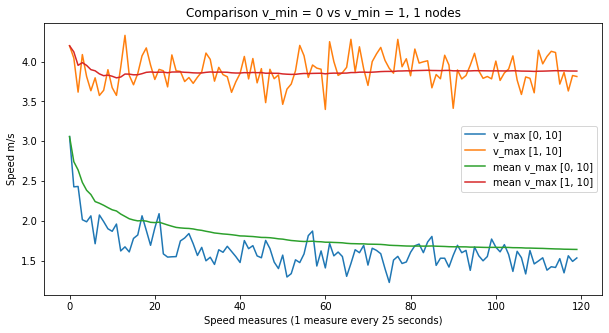

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def compare():
    def plot(measures0, measures1):  
        m0 = []
        for i in range(len(measures0)):
            m0.append(sum(measures0[:i+1]) / (i+1))
        m1 = []
        for i in range(len(measures1)):
            m1.append(sum(measures1[:i+1]) / (i+1))
        plt.figure(figsize=(10,5))
        plt.plot(measures0, label='v_max [0, 10]')
        plt.plot(measures1, label='v_max [1, 10]')
        plt.plot(m0, label='mean v_max [0, 10]')
        plt.plot(m1, label='mean v_max [1, 10]')
        plt.title("Comparison v_min = 0 vs v_min = 1, 1 nodes")
        plt.xlabel("Speed measures (1 measure every 25 seconds)")
        plt.ylabel("Speed m/s")
        plt.legend()
        plt.show()
    
    measures0 = run_set(200, 1, 0, 10)
    measures1 = run_set(200, 1, 1, 10)
    plot(measures0, measures1)
    
compare()

As we can see, choosing $v_\text{min}=1$ instead of $v_\text{min}=0$ yield pretty different results. From the plot (blue line) we can see how the problem we mentioned before about the possibility of sampling a low speed which lasts for a long time affects the performance. The orange line seems not affected by this problem (or affected less), there is a big improvement in the performance by just choosing $v_\text{min}=1$, and we do not notice a decreasing in time of the performance which is pretty obvious in the blue line case. We also should be aware that the first measures of the simulations with $v_\text{min}=0$ do not represent the overall behavior. In fact, by plotting the mean over time, we can better notice also this.